source: https://dhi.github.io/getting-started-with-mikeio/generic.html

一般性地，对于dfs文件的通用方法

mikeio.generic: methods that read any dfs file and outputs a new dfs file of the same type

concat: Concatenates files along the time axis

scale: Apply scaling to any dfs file

sum: Sum two dfs files

diff: Calculate difference between two dfs files

extract: Extract timesteps and/or items to a new dfs file

time-avg: Create a temporally averaged dfs file

quantile: Create temporal quantiles of dfs file

The generic methods works on larger-than-memory files as they process one time step at a time. This can however make them in-efficient for dfs0 processing!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mikeio
import mikeio.generic

# Concatenation 
2 files with overlapping timesteps

In [2]:
t1 = mikeio.read('mini_book/data/tide1.dfs1')
t1

<mikeio.Dataset>
Dimensions: (97, 10)
Time: 2019-01-01 00:00:00 - 2019-01-03 00:00:00
Items:
  0:  Level <Water Level> (meter)

In [3]:
t2 = mikeio.read('mini_book/data/tide2.dfs1')
t2

<mikeio.Dataset>
Dimensions: (97, 10)
Time: 2019-01-02 00:00:00 - 2019-01-04 00:00:00
Items:
  0:  Level <Water Level> (meter)

In [4]:
plt.plot(t1.time,t1[0].isel(x=1).values, label="File 1")
plt.plot(t2.time,t2[0].isel(x=1).values,'k+', label="File 2")
plt.legend()

C:\Users\jiyu\Anaconda3\lib\site-packages\mikeio\dataset.py:258: UserWarning: Indexing in MIKE IO 1.0 will not return a numpy array, but a mikeio.DataArray. More info: https://github.com/DHI/mikeio#readme
  warnings.warn(


AttributeError: 'numpy.ndarray' object has no attribute 'isel'

In [8]:
mikeio.generic.concat(infilenames=['mini_book/data/tide1.dfs1',
                                   'mini_book/data/tide2.dfs1'],
                      outfilename='concat.dfs1', keep='last')

In [9]:
c = mikeio.read('concat.dfs1')
c

<mikeio.Dataset>
Dimensions: (145, 10)
Time: 2019-01-01 00:00:00 - 2019-01-04 00:00:00
Items:
  0:  Level <Water Level> (meter)

In [10]:
c[0].isel(x=1).plot()

AttributeError: 'numpy.ndarray' object has no attribute 'isel'

# Extract time steps or items

method: extract()
1. time slice
2. specific items

In [11]:
infile = 'mini_book/data/tide1.dfs1'
mikeio.generic.extract(infile, 'extracted.dfs1', start='2019-01-02')

In [13]:
e = mikeio.read('extracted.dfs1')
e

<mikeio.Dataset>
Dimensions: (49, 10)
Time: 2019-01-02 00:00:00 - 2019-01-03 00:00:00
Items:
  0:  Level <Water Level> (meter)

In [14]:
infile = "mini_book/data/oresund_vertical_slice.dfsu"
mikeio.generic.extract(infile, "extracted.dfsu", items='Salinity', end=-2)

In [15]:
e = mikeio.read("extracted.dfsu")
e

<mikeio.Dataset>
Dimensions: (2, 441)
Time: 1997-09-15 21:00:00 - 1997-09-16 00:00:00
Items:
  0:  Z coordinate <ItemGeometry3D> (meter)
  1:  Salinity <Salinity> (PSU)

# Difference 

In [16]:
fn1 = "mini_book/data/oresundHD_run1.dfsu"
fn2 = "mini_book/data/oresundHD_run2.dfsu"
fn_diff = "oresundHD_difference.dfsu"
mikeio.generic.diff(fn1, fn2, fn_diff)

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1397.08it/s]


TypeError: read() got an unexpected keyword argument 'time'

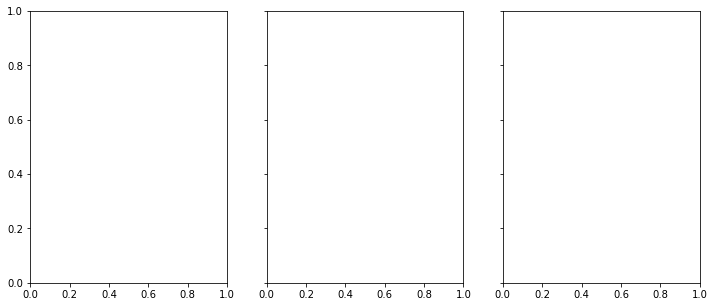

In [17]:
_, ax = plt.subplots(1,3, sharey=True, figsize=(12,5))
da = mikeio.read(fn1, time=-1)[0]
da.plot(vmin=0.06, vmax=0.27, ax=ax[0], title='run 1')
da = mikeio.read(fn2, time=-1)[0]
da.plot(vmin=0.06, vmax=0.27, ax=ax[1], title='run 2')
da = mikeio.read(fn_diff, time=-1)[0]
da.plot(vmin=-0.1, vmax=0.1, cmap='coolwarm', ax=ax[2], title='difference');

# Scaling 

adding a const. e.g. to adjust the datum

In [18]:
ds = mikeio.read("mini_book/data/gebco_sound.dfs2")
ds.Elevation.plot();

AttributeError: 'Dataset' object has no attribute 'Elevation'

In [19]:
ds['Elevation'][0,104,131]

-43.0

In [20]:
mikeio.generic.scale("mini_book/data/gebco_sound.dfs2","gebco_sound_local_datum.dfs2",offset=-2.1)

In [21]:
ds2 = mikeio.read("gebco_sound_local_datum.dfs2")
ds.Elevation.plot();

AttributeError: 'Dataset' object has no attribute 'Elevation'

In [22]:
ds2['Elevation'][0,104,131]

-45.099998474121094

# Spatially varying correction 

In [23]:
import numpy as np
factor = np.ones_like(ds['Elevation'][0].to_numpy())
factor.shape

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [24]:
import numpy as np
factor = np.ones_like(ds['Elevation'][0])
factor.shape

(264, 216)

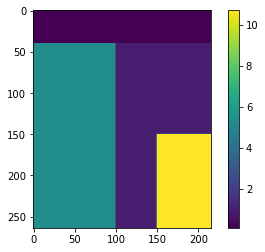

In [25]:
factor[:,0:100] = 5.3
factor[0:40,] = 0.1
factor[150:,150:] = 10.7
plt.imshow(factor)
plt.colorbar();

The 2d array must first be flipped upside down and then converted to a 1d vector using numpy.ndarray.flatten to match how data is stored in dfs files.

In [26]:
factor_ud = np.flipud(factor)
factor_vec  = factor_ud.flatten()
mikeio.generic.scale("mini_book/data/gebco_sound.dfs2","gebco_sound_spatial.dfs2",factor=factor_vec)

In [ ]:
ds3 = mikeio.read("gebco_sound_spatial.dfs2")
ds3.Elevation.plot()
plt.title("Spatial correction applied to dfs2")

# Clean up 

In [27]:
import os
os.remove("concat.dfs1")
os.remove("extracted.dfs1")
os.remove("extracted.dfsu")
os.remove("oresundHD_difference.dfsu")
os.remove("gebco_sound_local_datum.dfs2")
os.remove("gebco_sound_spatial.dfs2")